In [ ]:
%matplotlib inline

In [ ]:
!sudo -H pip install numpy pandas requests xmltodict

In [ ]:
import io
import json
import numpy as np
import os
import pandas as pd
import requests
import xml
import xmltodict

# Retrieve IATI Metadata

In [ ]:
# Use the IATI registry API to identify the metadata
# http://iatiregistry.org/registry-api

base_url = 'http://iatiregistry.org/api/3/action/package_search'

# Retrieve the current count by issuing a request that returns zero rows

query_data = {
    'q': 'extras_filetype:organisation',
    'start': 0,
    'rows': 0
}

response = requests.get(base_url, params = query_data).json()
count = response['result']['count']

# Also print out the help text in case it helps us in the future

print response['help']


    Searches for packages satisfying a given search criteria.

    This action accepts solr search query parameters (details below), and
    returns a dictionary of results, including dictized datasets that match
    the search criteria, a search count and also facet information.

    **Solr Parameters:**

    For more in depth treatment of each paramter, please read the `Solr
    Documentation <http://wiki.apache.org/solr/CommonQueryParameters>`_.

    This action accepts a *subset* of solr's search query parameters:


    :param q: the solr query.  Optional.  Default: `"*:*"`
    :type q: string
    :param fq: any filter queries to apply.  Note: `+site_id:{ckan_site_id}`
        is added to this string prior to the query being executed.
    :type fq: string
    :param sort: sorting of the search results.  Optional.  Default:
        'relevance asc, metadata_modified desc'.  As per the solr
        documentation, this is a comma-separated string of field names and
        sort-orderi

In [ ]:
# Retrieve all the pages of metadata from the cache file (if available)
# or from the server (if no cache file is available)

if os.path.isfile('organization_metadata.json'):
    with io.open('organization_metadata.json', 'r', encoding = 'utf-8') as metadata_file:
        metadata = json.load(metadata_file)
else:
    metadata = []

    # Allowed page size is 100

    for i in range(0, count, 100):
        print 'Retrieved', i, 'of', count, 'results'

        query_data = {
            'q': 'extras_filetype:organisation',
            'start': i,
            'rows': 100
        }

        response = requests.get(base_url, params = query_data).json()
        metadata.extend(response['result']['results'])

    print 'Retrieved', count, 'of', count, 'results'

Retrieved 0 of 289 results
Retrieved 100 of 289 results
Retrieved 200 of 289 results
Retrieved 289 of 289 results


In [ ]:
# Cache the metadata to disk so that we don't have to fetch it

with open('organization_metadata.json', 'w') as metadata_file:
    json.dump(metadata, metadata_file)

# Validate IATI Metadata

In [ ]:
# Take a quick look at the field names and get a feel for the data

df = pd.DataFrame(metadata)

df.columns.values

array([u'author', u'author_email', u'extras', u'groups', u'id', u'isopen',
       u'license_id', u'license_title', u'license_url', u'maintainer',
       u'maintainer_email', u'metadata_created', u'metadata_modified',
       u'name', u'notes', u'num_resources', u'num_tags', u'organization',
       u'owner_org', u'private', u'relationships_as_object',
       u'relationships_as_subject', u'resources', u'revision_id',
       u'revision_timestamp', u'state', u'tags', u'title',
       u'tracking_summary', u'type', u'url', u'version'], dtype=object)

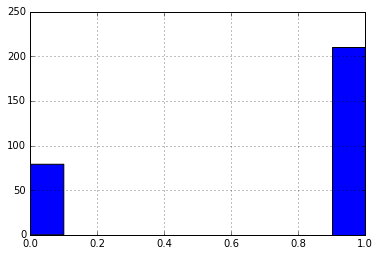

In [ ]:
# There's an isopen column indicating whether the data set is open
# to be used for general purposes. Let's see the distribution.

df['isopen'].hist()

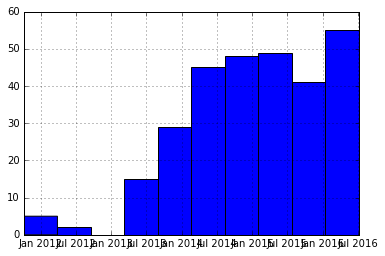

In [ ]:
# There is a metadata column on the timestamp when a revision was made,
# which we can use to see if the data is out of date or not.

pd.to_datetime(df['revision_timestamp']).hist()

# Identify Resources

In [ ]:
# Grab the URLs associated with our metadata

metadata_titles = {}
metadata_resources = {}

for metadata_item in metadata:
    if not metadata_item['isopen']:
        continue

    title = metadata_item['title']
    short_name = metadata_item['name']

    resources = metadata_item['resources']
    resource_urls = [x for x in set([resource_item['url'] for resource_item in resources])]

    metadata_titles[short_name] = title
    metadata_resources[short_name] = resource_urls

In [ ]:
# Check our metadata for duplicate URLs

for short_name, resource_urls in metadata_resources.iteritems():
    if len(resource_urls) > 1:
        print short_name
        print resource_urls

In [ ]:
# It looks like there are no actual duplicates, except for aidstream.org
# which has a URL listed for both aidstream.org and www.aidstream.org
# This means we should be able to safely download everything!

with io.open('download-iati-orgs.sh', 'w', encoding='utf8') as iati_file:
    iati_file.write(u'mkdir -p iati-orgs\n')

    for short_name, resource_urls in metadata_resources.iteritems():
        iati_filename = 'iati-orgs/' + short_name + '.xml'

        if os.path.isfile(iati_filename) and os.path.getsize(iati_filename) > 0:
            continue

        iati_file.write('# %s\n' % metadata_titles[short_name])
        iati_file.write('curl -Ls "%s" > %s &\n' % (resource_urls[0], iati_filename))

    iati_file.write(u'wait\n')

In [ ]:
!chmod u+x download-iati-orgs.sh
!./download-iati-orgs.sh

In [ ]:
# Clean up anything that wound up with a file size of zero

for xml_name in os.listdir('iati-orgs'):
    iati_filename = 'iati-orgs/' + xml_name

    if os.path.getsize(iati_filename) == 0:
        os.remove(iati_filename)

# Create Resource Archive

In [ ]:
!rm -f iati-orgs.tar.gz
!tar -cf iati-orgs.tar iati-orgs
!gzip iati-orgs.tar
!aws s3 cp iati-orgs.tar.gz s3://mdang.w210/

upload: ./iati-orgs.tar.gz to s3://mdang.w210/iati-orgs.tar.gz
